# Imports

In [1]:
from matplotlib.colors import LogNorm
from numba import cfunc, vectorize
from numba.types import intc, CPointer, float64
import numpy as np
import os
import pickle
from scipy import LowLevelCallable
from scipy.integrate import quad
from scipy.optimize import minimize_scalar
from scipy.interpolate import griddata
import itertools

from background_models import bg_dampe
from constants import plot_obs, dampe_es, dampe_excess_iflux, fermi_psf
from constants import dampe_excess_bin_low, dampe_excess_bin_high
from constants import speed_of_light, kpc_to_cm, rho_earth
from constants import plot_obs

from finite_clump import rho, luminosity, lum_to_rho_norm, mass
from finite_clump import normalize_clump_dampe, luminosity_dampe
from finite_clump import dphi_de_e, dphi_de_e_dampe
from finite_clump import dphi_de_gamma, dphi_de_gamma_dampe
from finite_clump import gamma_ray_extent, constrain_ep_spec
from nfw_clump import NFW_params
from tt_clump import TT_params

from pointlike_clump import dphi_de_e_pt, dphi_de_e_dampe_pt, lum_dampe_pt
from pointlike_clump import dphi_de_gamma_pt, dphi_de_gamma_dampe_pt
from pointlike_clump import constrain_ep_spec_pt
colors = [c["color"] for c in plt.rcParams['axes.prop_cycle']]

In [2]:
lum_levels = [9e30, 2e31, 5e31, 9e31, 2e32, 5e32, 9e32, 2e33]
rho_rel_levels = [1.2, 1.7, 3, 5, 9, 15, 25, 45, 85]
dphi_de_g_levels = [1e-16, 2e-16, 4e-16, 8e-16, 1e-5, 2e-15, 4e-15, 1e-14, 4e-14, 7e-14]
extent_levels = [1, 3, 6, 15, 30, 60, 125, 250, 350, 450]

# Old plots
Need to redo

## Clump luminosity
WARNING: making $r_s$ too small (in practice, less than about 0.001 kpc for $d \sim 1$ kpc) leads to numerical problems in the luminosity and $J$ factor integrals.

In [2]:
ds = np.linspace(0.1, 1.5, 10)
rss = np.logspace(-3, -1, 3)

In [3]:
lums_pt = np.array([lum_dampe_pt(d, bg_dampe) for d in ds])

In [4]:
lums = {}

for rs in rss:
    lums[rs] = np.array([lum_dampe(d, rs, bg_dampe) for d in ds])

/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best wh

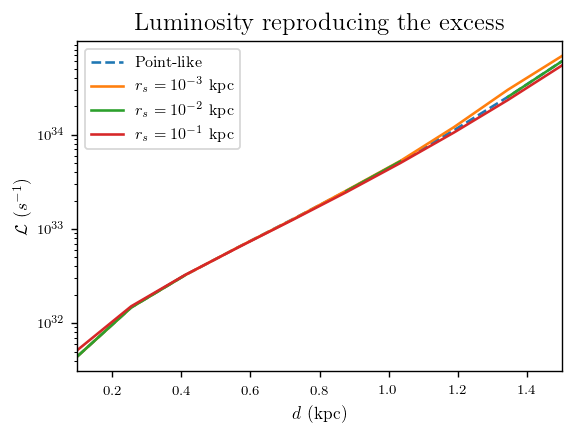

In [8]:
plt.plot(ds, lums_pt, '--', label='Point-like')
for rs in rss:
    plt.plot(ds, lums[rs], label=r'$r_s = 10^{%i}$ kpc' % np.log10(rs))

plt.xlim(ds[[0, -1]])
plt.yscale("log")
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$\mathcal{L}~(s^{-1})$")
plt.legend()
plt.title("Luminosity reproducing the excess")

plt.savefig('figures/lum.pdf', bbox_inches='tight')

## $e^+ + e^-$ spectrum

In [82]:
clump_e_fluxes = {}
pt_e_fluxes = {}

e_es = np.logspace(np.log10(1300), np.log10(1550), 150)

for d in [0.1, 0.3]:
    clump_e_fluxes[d] = dphi_de_e_dampe(e_es, d, 1.5, bg_dampe, gamma=0.5)
    pt_e_fluxes[d] = dphi_de_e_dampe_pt(e_es, d, bg_dampe)

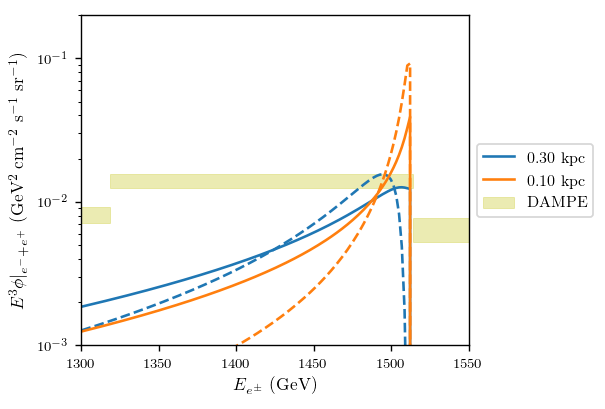

In [83]:
power = 3

plot_obs(power, highlight_excess_bins=False)

for d, c in zip(clump_e_fluxes.iterkeys(), colors):
    plt.plot(e_es, e_es**power * 2*clump_e_fluxes[d],
             label="%.2f kpc" % d, color=c)
    plt.plot(e_es, e_es**power * 2*pt_e_fluxes[d],
             '--', color=c)

plt.xlim(1300, 1550)
plt.ylim(1e-3, 2e-1)
# plt.xscale("log")
plt.yscale("log")

plt.xlabel(r"$E_{e^\pm}$ (GeV)")
plt.ylabel(r"$E^%i \phi|_{e^-+e^+}$ (GeV$^{%i}$ cm$^{-2}$ s$^{-1}$ sr$^{-1}$)" %
           (power, power - 1))

# Shrink current axis by 20%
box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
lgd = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# plt.savefig('figures/ep_spectrum.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

## $\gamma$ spectrum
WARNING: making $r_s$ too small (in practice, less than about 0.001 kpc for $d \sim 1$ kpc) leads to numerical problems in the luminosity and $J$ factor integrals.

### Flux at 10 GeV as a function of $d$ and $r_s$

In [85]:
clump_10GeV_fluxes_d = {}

e_gammas = np.logspace(np.log10(1300), np.log10(1550), 150)
ds = np.logspace(-2, 0, 50) # kpc
rss = np.logspace(-3, -1, 3)
e_gamma_benchmark = 10. # GeV

In [86]:
for rs in rss:
    clump_10GeV_fluxes_d[rs] = np.array([dphi_de_gamma_dampe([e_gamma_benchmark],
                                                             np.cos(fermi_psf),
                                                             d, rs, bg_dampe)
                                       for d in ds]).flatten()

pt_10GeV_fluxes = np.array([dphi_de_gamma_dampe_pt([e_gamma_benchmark], d, bg_dampe)
                            for d in ds]).flatten()

In [ ]:
power = 0

plt.plot(ds, e_gamma_benchmark**power * pt_10GeV_fluxes_d, '--', label="Point-like")
for rs in rss:
    plt.plot(ds, e_gamma_benchmark**power * clump_10GeV_fluxes_d[rs],
             label=r"$r_s = 10^{%i}$ kpc" % np.log10(rs))

plt.xlim(ds[[0, -1]])
plt.xscale("log")
plt.yscale("log")

plt.title("Photon flux from DM clump")
plt.xlabel(r"$d$ (kpc)")
if power == 0:
    plt.ylabel(r"$\phi|_{\gamma}(E_\gamma = %i)$ (GeV$^{-1}$ cm$^{-2}$ s$^{-1}$ sr$^{-1}$)"
               % e_gamma_benchmark)
else:
    plt.ylabel((r"$E^%i \phi|_{\gamma}(E_\gamma = %i)$ "
                r"(GeV$^{%i}$ cm$^2$ $s$ $sr$)$^{-1}$") 
               % (e_gamma_benchmark, power, 1-power))

box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width * 0.8, box.height])
lgd = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('figures/gamma_ray_flux_d.pdf',
            bbox_extra_artists=(lgd,), bbox_inches='tight')

### Flux at 10 GeV as a function of $\Delta\Omega$

In [56]:
clump_10GeV_fluxes_dOmegas = {}

e_gammas = np.logspace(np.log10(1300), np.log10(1550), 150) # GeV
rss = np.logspace(-3, -1, 3) # kpc
thetas = np.logspace(np.log10(fermi_psf)-1, 0, 100) # rad
dOmegas = 2.*np.pi*(1. - np.cos(thetas)) # sr
e_gamma_benchmark = 10. # GeV

In [57]:
for rs in rss:
    clump_10GeV_fluxes_dOmegas[rs] = np.array(dphi_de_gamma_dampe([e_gamma_benchmark],
                                                                   np.cos(thetas),
                                                                   1., rs,
                                                                  bg_dampe)).flatten()

pt_10GeV_fluxes_dOmegas = np.array(len(thetas) * 
                                   [dphi_de_gamma_dampe_pt([e_gamma_benchmark],
                                                           1., bg_dampe)]).flatten()

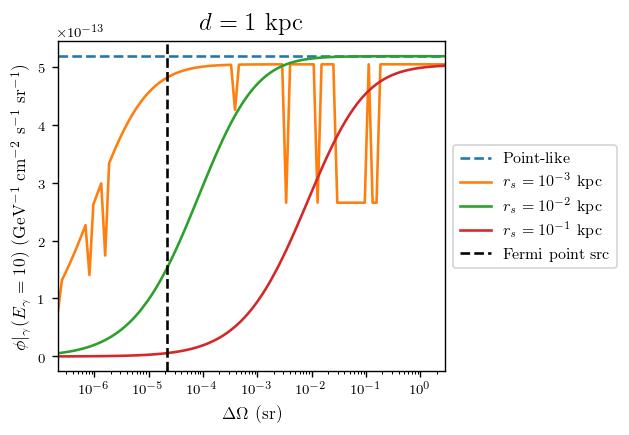

In [60]:
power = 0

plt.plot(dOmegas,
         e_gamma_benchmark**power * pt_10GeV_fluxes_dOmegas,
         '--', label="Point-like")
for rs in rss:
    plt.plot(dOmegas,
             e_gamma_benchmark**power * clump_10GeV_fluxes_dOmegas[rs],
             label=r"$r_s = 10^{%i}$ kpc" % np.log10(rs))

# Solid angle corresponding to Fermi's PSF
plt.axvline(2.*np.pi*(1.-np.cos(fermi_psf)),
            color='k', linestyle="dashed", label="Fermi point src")

plt.xlim(dOmegas[[0, -1]])
plt.xscale("log")
plt.title(r"$d=1$ kpc")
plt.xlabel(r"$\Delta\Omega$ (sr)")
if power == 0:
    plt.ylabel(r"$\phi|_{\gamma}(E_\gamma = %i)$ (GeV$^{-1}$ cm$^{-2}$ s$^{-1}$ sr$^{-1}$)"
               % e_gamma_benchmark)
else:
    plt.ylabel((r"$E^%i \phi|_{\gamma}(E_\gamma = %i)$ "
                r"(GeV$^{%i}$ cm$^2$ $s$ $sr$)$^{-1}$") 
               % (e_gamma_benchmark, power, 1-power))

box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width * 0.8, box.height])
lgd = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('figures/gamma_ray_flux_dOmega.pdf',
            bbox_extra_artists=(lgd,), bbox_inches='tight')

## $\rho_s$

In [16]:
ds = np.linspace(0.01, 1, 100)
rhoss = np.array([rhos_dampe(d, 0.2, bg_dampe) for d in ds])

Text(0.5,1,'$r_s = 0.2$ kpc')

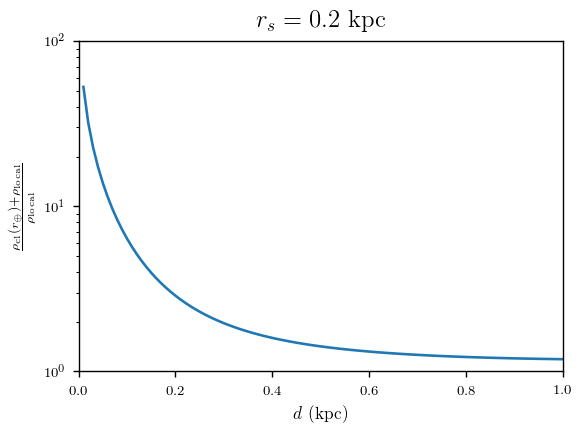

In [18]:
rho_local = 0.3

plt.plot(ds, [(rho_NFW(d, rs=0.1, rhos=rhos, gamma=0.5) + rho_local) / rho_local
              for d, rhos in zip(ds, rhoss)])

plt.yscale("log")
plt.xlim([0, 1])
plt.ylim(1e0, 1e2)

plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$\frac{\rho_{\mathrm{cl}}(r_\oplus) + \rho_{\mathrm{local}}}{\rho_{\mathrm{local}}}$")
plt.title(r"$r_s = 0.2$ kpc")

# plt.savefig('figures/rhos_rs_0.1.pdf', bbox_inches='tight')

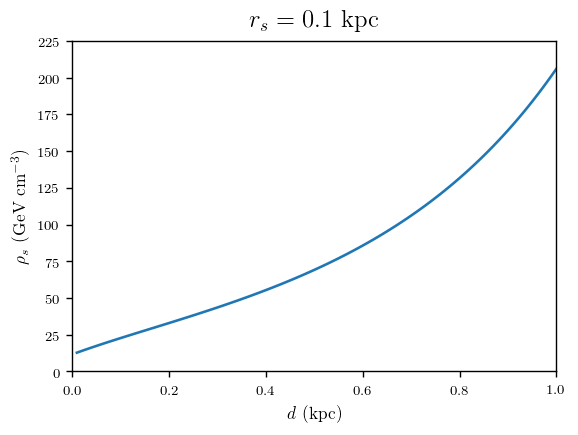

In [90]:
plt.plot(ds, rhoss)

plt.xlim([0, 1])
plt.ylim(0, 225)
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$\rho_s$ (GeV cm$^{-3}$)")
plt.title(r"$r_s = 0.1$ kpc")

plt.savefig('figures/rhos_rs_0.1.pdf', bbox_inches='tight')